In [1]:
import math
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
from sklearn.model_selection import train_test_split

2021-09-24 16:18:00.537296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-24 16:18:00.537322: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
BATCH_SIZE = 16
MODELS_DIRECTORY = "../models"
TRAIN_FILE_PATH = "../data/training.csv"

In [3]:
def get_rgbimage_from_string(image_pixels_string):
    
    image_pixels_list = [int(point) for point in image_pixels_string.split(" ")]
    image_side = int(np.sqrt(len(image_pixels_list)))
    image = np.reshape(image_pixels_list, (image_side, image_side))
    image = np.stack([image, image, image], axis=2)
    
    return image

def display_image(image):
    
    plt.figure()
    plt.imshow(image.astype(np.uint8))
    
    return

def get_image_keypoints(index):
    
    keypoints = train_df.iloc[index][:-1].values
    
    return keypoints

def draw_keypoints(image, keypoints):
    
    for i in np.linspace(0, len(keypoints)-2, 15, dtype=int):
        if math.isnan(keypoints[i]) or math.isnan(keypoints[i+1]):
            continue
        if keypoints[i] < 0 or keypoints[i] > 95:
            continue
        if keypoints[i+1] < 0 or keypoints[i+1] > 95:
            continue
        image[int(keypoints[i+1]), int(keypoints[i])] = 255
        
    return image

In [4]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, images, keypoints, augmentations, batch_size, shuffle=True):
        
        self.images = images
        self.keypoints = keypoints
        self.augmentations = augmentations
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.images))
        
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        images = [self.images[k] for k in indexes]
        keypoints = [self.keypoints[k] for k in indexes]
        images, keypoints = self.__data_generation(images, keypoints)

        return (images, keypoints)

    def __data_generation(self, images, keypoints):
        
        len_image_side = images[0].shape[0]
        len_keypoints = len(keypoints[0])
        batch_images = np.empty((self.batch_size, len_image_side, len_image_side, 3), dtype="float32")
        batch_keypoints = np.empty((self.batch_size, len_keypoints), dtype="float32")

        for i, (image, keypoint) in enumerate(zip(images, keypoints)):
            keypoint_pairs = []
            
            for j in np.arange(0, len(keypoint), 2):
                keypoint_pairs.append(Keypoint(x=int(keypoint[j]), y=int(keypoint[j+1])))
            
            kps_obj = KeypointsOnImage(keypoint_pairs, shape=image.shape)
            (new_image, new_kps_obj) = self.augmentations(image=image, keypoints=kps_obj)
            batch_images[i] = new_image
            kp_temp = []

            for keypoint in new_kps_obj:
                kp_x = np.nan_to_num(keypoint.x)
                kp_y = np.nan_to_num(keypoint.y)
                
                if kp_x < 0 or kp_x > 95:
                    kp_x = 0
                if kp_y < 0 or kp_y > 95:
                    kp_y = 0
                    
                kp_temp.append(kp_x)
                kp_temp.append(kp_y)

            batch_keypoints[i] = kp_temp
        
        return batch_images, batch_keypoints

In [5]:
train_df = pd.read_csv(TRAIN_FILE_PATH)

In [6]:
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [7]:
train_df = train_df.fillna(0)

In [8]:
no_rows, no_columns = train_df.shape

In [9]:
labels = []

for i in range(no_rows):
    labels.append(train_df.iloc[i][:-1].values.astype(float))

In [10]:
images = []

for i in range(no_rows):
    images.append(get_rgbimage_from_string(train_df.iloc[i]["Image"]).astype(float))

In [11]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

In [12]:
train_aug = iaa.Sequential([iaa.Resize(X_train[0].shape[0:2], interpolation="linear"), iaa.Fliplr(0.3), iaa.Sometimes(0.5, iaa.Affine(rotate=(-10, 10), scale=(0.75, 1.25)))])
test_aug = iaa.Sequential([iaa.Resize(X_train[0].shape[0:2], interpolation="linear")])

In [13]:
train_dataset = KeyPointsDataset(X_train, y_train, train_aug, BATCH_SIZE)
val_dataset = KeyPointsDataset(X_train, y_train, test_aug, BATCH_SIZE)

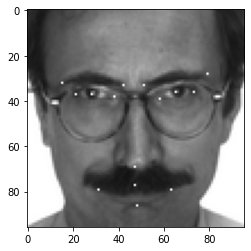

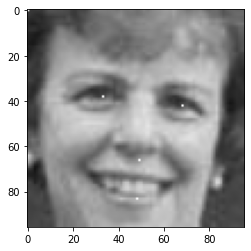

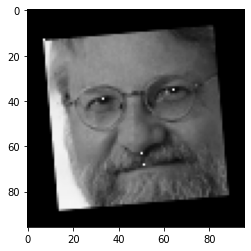

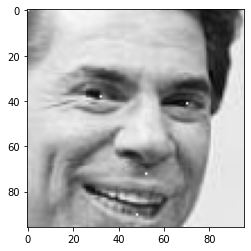

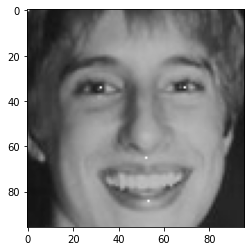

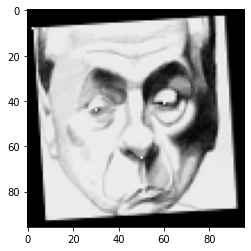

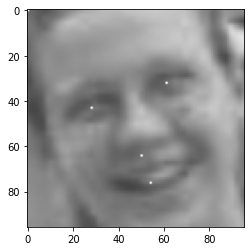

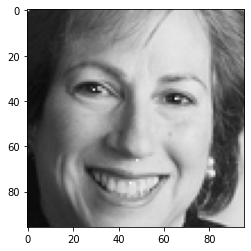

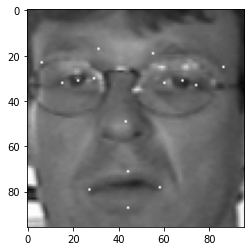

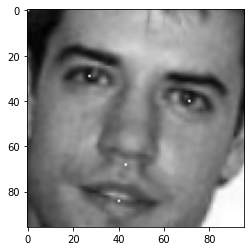

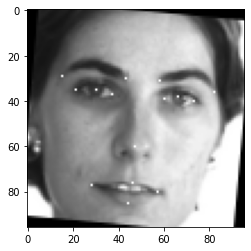

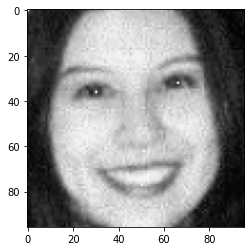

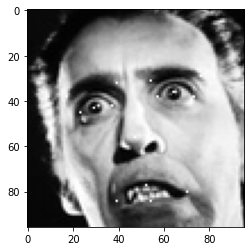

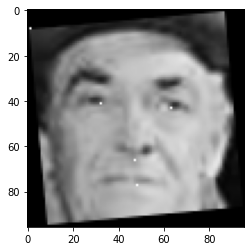

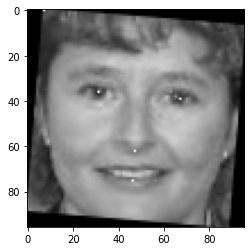

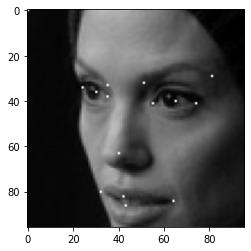

In [14]:
count = 0

for images, labels in train_dataset:
    count += 1
    
    for image, label in zip(images, labels):
        image_w_keypoints = draw_keypoints(image.copy(), label)
        display_image(image_w_keypoints)
    
    if count == 1:
        break

In [15]:
def get_model(base_trainable=False):
    
    base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(96, 96, 3))
    base_model.trainable = base_trainable
    inputs = tf.keras.Input(shape=(96, 96, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(30)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [16]:
model = get_model()

2021-09-24 16:18:53.562988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-24 16:18:53.563027: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-24 16:18:53.563056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ali-Latitude-E5470): /proc/driver/nvidia/version does not exist
2021-09-24 16:18:53.563314: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODELS_DIRECTORY + "/model-base-frozen.h5", monitor="val_loss", save_best_only=True, mode="min"),
]

In [18]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))

In [19]:
if not os.path.exists(MODELS_DIRECTORY):
    os.makedirs(MODELS_DIRECTORY)

In [20]:
history = model.fit(train_dataset, validation_data=val_dataset, callbacks=callbacks, epochs=5)

2021-09-24 16:19:50.110846: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-24 16:19:50.133108: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499950000 Hz


Epoch 1/5
396/396 [==============================] - 215s 538ms/step - loss: 446.5306 - val_loss: 242.2640


/home/ali/Desktop/Kaggle-facial-keypoints/facial-keypoints-env/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/5
396/396 [==============================] - 218s 551ms/step - loss: 340.2207 - val_loss: 215.0748
Epoch 3/5
396/396 [==============================] - 205s 517ms/step - loss: 334.6543 - val_loss: 197.0884
Epoch 4/5
396/396 [==============================] - 206s 521ms/step - loss: 313.3026 - val_loss: 186.0904
Epoch 5/5
396/396 [==============================] - 207s 523ms/step - loss: 318.2784 - val_loss: 185.8375


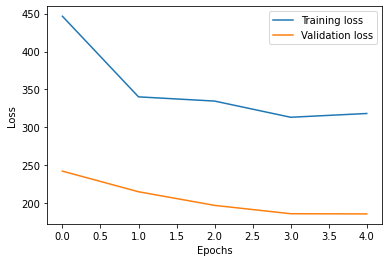

In [21]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [23]:
model_file = os.listdir(MODELS_DIRECTORY)[-1]

In [27]:
model = tf.keras.models.load_model(MODELS_DIRECTORY + "/" + model_file)

In [28]:
X_val_tensor = tf.convert_to_tensor(X_val)
predictions = model.predict(X_val_tensor)

In [29]:
X_val_tensor.shape

TensorShape([705, 96, 96, 3])

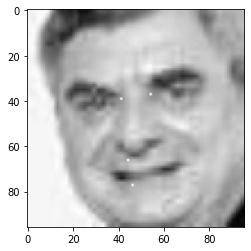

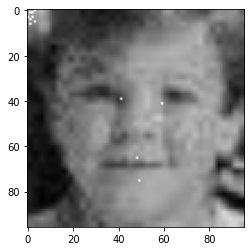

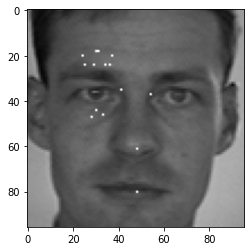

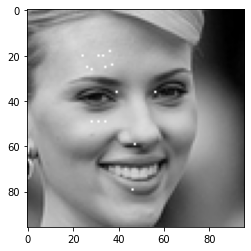

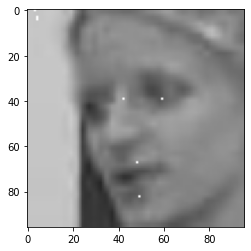

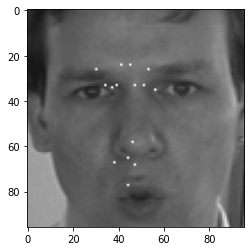

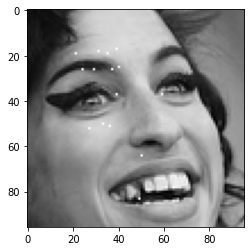

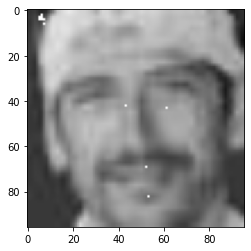

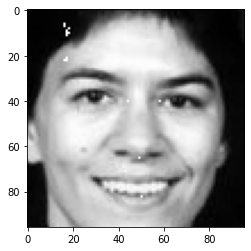

In [30]:
count = 0

for image, prediction in zip(X_val, predictions):
    count += 1
        
    if count == 10:
        break
    
    display_image(draw_keypoints(image.copy(), prediction))

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                61470     
Total params: 23,649,182
Trainable params: 61,470
Non-trainable params: 23,587,712
____________________________________________

In [32]:
model.layers[3].trainable = True

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 96, 96, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 3, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                61470     
Total params: 23,649,182
Trainable params: 23,596,062
Non-trainable params: 53,120
____________________________________________

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(MODELS_DIRECTORY + "/model-finetuned.h5", monitor="val_loss", save_best_only=True),
]

In [38]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.0003))

In [39]:
history = model.fit(train_dataset, callbacks=callbacks, validation_data=val_dataset, epochs=1)

201/396 [==============>...............] - ETA: 5:03 - loss: 324.3711

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions = model.predict(X_val_tensor)

In [ ]:
count = 0
for image, prediction in zip(X_val, predictions):
    count += 1
    if count == 50:
        break
    display_image(draw_keypoints(image.copy(), prediction))